In [1]:
from tqdm import tqdm
import torch

from data.CRSPLoader import CRSPLoader
from loss_functions.SharpeLoss import SharpeLoss
from models.TGNNPO import TGNNPO

In [2]:
device = torch.device('cpu')
window_length = 50
step_length = 5

# load and prepare dataset
loader = CRSPLoader(load_data=True)
etf_tickers = ['SPY', 'XLF', 'XLB', 'XLK', 'XLV', 'XLI', 'XLU', 'XLY', 'XLP', 'XLE']
loader._update_ticker_index(ticker_list=etf_tickers)
dataset = loader.get_dataset(data=loader.select_tickers(tickers=etf_tickers), window_length=window_length, step_length=step_length)


Loading in saved CRSP data...


/Users/dylansandfelder/Documents/Work/DanielCollab/graph-portfolio-opt/src/data/CRSPLoader.py:27: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  self._load_data(self.load_path)


Generating edge weights from raw data...


Loading edge files: 100%|██████████| 245/245 [00:12<00:00, 19.44it/s]


Generating CRSP dataset...
Generating feature matrix...


100%|██████████| 5531/5531 [00:14<00:00, 368.87it/s]


Generating target matrix...


100%|██████████| 5531/5531 [00:03<00:00, 1842.55it/s]


In [3]:
# optimization hyperparameters
learning_rate = 0.1

# how recently should we consider our model to be "trained" by?
lookback_loss_mean = 200

# training hyperparameters
epochs = 15

Epoch: 1, sharpe (mean loss): -1.72707:   0%|          | 0/1097 [00:00<?, ?it/s]


IndexError: list index out of range

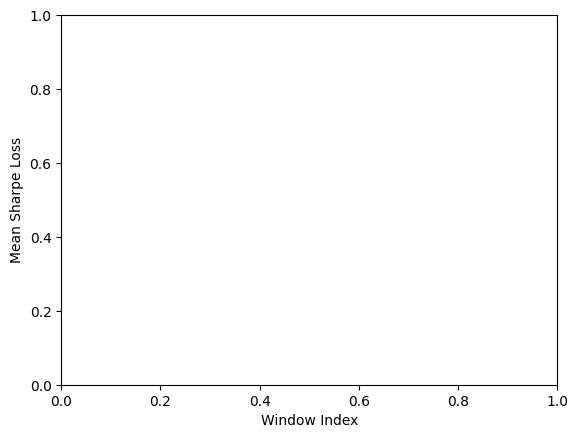

In [4]:
import matplotlib.pyplot as plt
plt.xlabel('Window Index')
plt.ylabel('Mean Sharpe Loss')
# (1) model
model = TGNNPO(node_features=loader.num_features, periods=window_length).to(device)

# (2) loss function
lossfn = SharpeLoss()

# (3) training procedure
model.train()
for epoch in range(epochs): 
    # optimizer resets itself between epochs
    cur_max_lr = learning_rate
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=(learning_rate/10.0))
    loss_history = []
    mean_history = []
    pbar = tqdm(enumerate(dataset), total=dataset.get_num_batches())
    for steps, batch in pbar:
        X_batch = batch.x
        static_edge_index = batch.edge_index
        edge_weights = batch.edge_weight
        prices_batch = batch.y
        
        
        optimizer.zero_grad()
        
        # predict portfolio weights
        weights_pred = model(X_batch, static_edge_index, edge_weights)
  
        # sharpe ratio loss
        loss = lossfn(prices_batch, weights_pred, ascent=True)
        loss_history.append(loss.item())
        if len(loss_history) < lookback_loss_mean:
            mean_history.append(-1 * sum(loss_history) / len(loss_history))
        else:
            mean_history.append(-1 * sum(loss_history[(-1 * lookback_loss_mean):]) / len(loss_history[(-1 * lookback_loss_mean):]))
        pbar.set_description("Epoch: %d, sharpe (mean loss): %1.5f" % (epoch + 1, mean_history[-1]))
        
        if len(mean_history) > 1 and  mean_history[-2] - mean_history[-1] > 0.05:
            for g in optimizer.param_groups:
                g['lr'] = cur_max_lr

        loss.backward()
        optimizer.step()
    plt.plot(list(range(dataset.get_num_batches())), mean_history, linewidth=1, label=f'Epoch {epoch+1}')
    learning_rate = learning_rate / 1.5
plt.legend()